<div style="font-size: 16px;"><strong>
    CONCLUSION: We pick the model generated by epoch 5 because it has the lowest validation loss and highest validation accuracy!
</strong></div>

In [1]:
!pip install pydicom -q
!pip uninstall torch torchvision -y
!pip install torch==2.1 torchvision==0.16 -q
!pip install -qU pycocotools
!pip install -qU wandb

# Configs

In [2]:
for name in list(globals()):
    if not name.startswith("_"):  # Avoid deleting built-in and special variables
        del globals()[name]

In [3]:
CONDITION = 'LeftNeuralForaminalNarrowing'

## Load libraries

In [4]:
import os
import time
from datetime import datetime
import numpy as np
import collections
import random
import torch

from matplotlib import animation, rc
import pandas as pd

import matplotlib.pyplot as plt

## Reproducibility

In [5]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Directories

In [6]:
PROJECT_DIR = '/home/jupyter'
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
SRC_DIR = os.path.join(PROJECT_DIR, 'src')
CROP_DIR = os.path.join(DATA_DIR, 'train_crops', '02_train_disc_detection', CONDITION)
os.makedirs(CROP_DIR, exist_ok=True)
MODEL_DIR = os.path.join(PROJECT_DIR, 'models', '04_train_severity_classification', CONDITION)
os.makedirs(MODEL_DIR, exist_ok=True)

## Functions

In [7]:
with open(os.path.join(SRC_DIR, 'pipeline_severity_classification.py')) as file:
    exec(file.read())

## Hyperparameters

In [8]:
CONFIG = dict(
    num_epochs=6,
    batch_size=50,
    lr=0.0001,
    lr_step_size=3,
    lr_gamma=0.1
)

## Metadata

In [9]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'processed_metadata', CONDITION, 'train.csv'))
val_df = pd.read_csv(os.path.join(DATA_DIR, 'processed_metadata', CONDITION, 'val.csv'))

<div style="font-size: 16px;">
    Add the cropped image path to metadata:
</div>

In [10]:
LABELS_DICT = {
    1: "L1_L2",
    2: "L2_L3",
    3: "L3_L4",
    4: "L4_L5",
    5: "L5_S1"
}

In [11]:
def get_cropped_image_path(row):
    return f"{CROP_DIR}/{row['study_id']}/{row['series_id']}/{LABELS_DICT[row['level_code']]}/{row['instance_number']}.pt"

train_df['cropped_image_path'] = [get_cropped_image_path(row) for i, row in train_df.iterrows()]
val_df['cropped_image_path']   = [get_cropped_image_path(row) for i, row in val_df.iterrows()]

## Some example cropped images

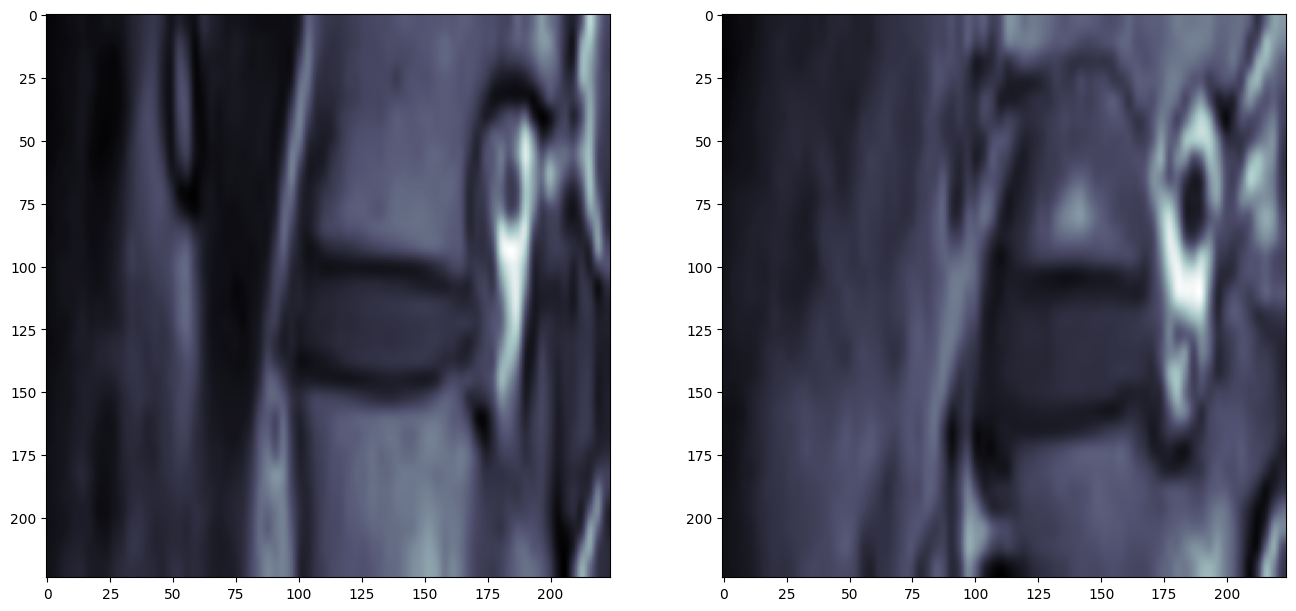

In [12]:
tmp_ds = RSNACroppedImageDataset(train_df)
tmp_dl = torch.utils.data.DataLoader(
  tmp_ds,
  batch_size=1,
  shuffle=False
)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,16))
for i, (img, label) in enumerate(tmp_dl):
    if i == 2: break
    y = img[0][0].numpy()
    ax[i].imshow(y, cmap=plt.cm.bone)
del tmp_ds, tmp_dl

# Training

## Load Model

In [13]:
model = load_model_severity_classification()

In [14]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters in the model: {count_trainable_parameters(model)}")

Number of trainable parameters in the model: 27584877


## Test forward

In [15]:
# Create dataset and dataloader
dataset = RSNACroppedImageDataset(train_df)
data_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=1,
  shuffle=True
)

In [16]:
# Get first input from dataloader
images, labels = next(iter(data_loader))

# Inference
model.to('cpu')
model.eval()
with torch.inference_mode():
    predictions = model(images)

In [17]:
print(f"Predicted values for 3 classes in one sample: {predictions.squeeze().tolist()}")

Predicted values for 3 classes in one sample: [-0.04924413561820984, -0.09369999170303345, -0.016873721033334732]


## Train and validate

In [18]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()
# !nvidia-smi

In [19]:
model_pipeline(config=CONFIG, model=model, model_dir=MODEL_DIR, train_df=train_df, val_df=val_df, device=device, limit=None)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ning-shen (ning-shen-university-of-british-columbia). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.6
wandb: Run data is saved locally in /home/jupyter/notebooks/wandb/run-20241112_172716-7mi1sz39
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run robust-smoke-30
wandb: ⭐️ View project at https://wandb.ai/ning-shen-university-of-british-columbia/pytorch-demo
wandb: 🚀 View run at https://wandb.ai/ning-shen-university-of-british-columbia/pytorch-demo/runs/7mi1sz39
  0%|          | 0/6 [00:00<?, ?it/s]

Loss after 00950 examples: 0.946
Batch 20 Metrics:
  Accuracy: 76.63%
  Class 0: Precision: 0.7971, Recall: 0.9538, F1-score: 0.8685
  Class 1: Precision: 0.1429, Recall: 0.0298, F1-score: 0.0493
  Class 2: Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Loss after 01950 examples: 0.900
Batch 40 Metrics:
  Accuracy: 69.80%
  Class 0: Precision: 0.7486, Recall: 0.9090, F1-score: 0.8210
  Class 1: Precision: 0.2043, Recall: 0.0888, F1-score: 0.1238
  Class 2: Precision: nan, Recall: 0.0000, F1-score: 0.0000
Loss after 02950 examples: 0.900
Batch 60 Metrics:
  Accuracy: 76.40%
  Class 0: Precision: 0.7640, Recall: 1.0000, F1-score: 0.8662
  Class 1: Precision: nan, Recall: 0.0000, F1-score: 0.0000
  Class 2: Precision: nan, Recall: 0.0000, F1-score: 0.0000
Loss after 03950 examples: 0.833
Batch 80 Metrics:
  Accuracy: 77.20%
  Class 0: Precision: 0.7720, Recall: 1.0000, F1-score: 0.8713
  Class 1: Precision: nan, Recall: 0.0000, F1-score: 0.0000
  Class 2: Precision: nan, Recall: 0.00

 17%|█▋        | 1/6 [09:55<49:38, 595.76s/it]

Validation Metrics:
  Loss: 0.8703
  Accuracy: 79.92%
  Class 0: Precision: 0.8092, Recall: 0.9892, F1-score: 0.8902
  Class 1: Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
  Class 2: Precision: 0.1176, Recall: 0.0385, F1-score: 0.0580
Loss after 08070 examples: 0.763
Batch 20 Metrics:
  Accuracy: 77.37%
  Class 0: Precision: 0.7849, Recall: 0.9865, F1-score: 0.8743
  Class 1: Precision: 0.3077, Recall: 0.0229, F1-score: 0.0426
  Class 2: Precision: 0.1429, Recall: 0.0286, F1-score: 0.0476
Loss after 09070 examples: 0.760
Batch 40 Metrics:
  Accuracy: 72.40%
  Class 0: Precision: 0.8338, Recall: 0.8423, F1-score: 0.8380
  Class 1: Precision: 0.3160, Recall: 0.3764, F1-score: 0.3436
  Class 2: Precision: nan, Recall: 0.0000, F1-score: 0.0000
Loss after 10070 examples: 0.764
Batch 60 Metrics:
  Accuracy: 73.30%
  Class 0: Precision: 0.8463, Recall: 0.8752, F1-score: 0.8605
  Class 1: Precision: 0.4054, Recall: 0.2332, F1-score: 0.2961
  Class 2: Precision: 0.2157, Recall: 0.4783, 

 33%|███▎      | 2/6 [12:09<21:35, 323.79s/it]

Validation Metrics:
  Loss: 0.6846
  Accuracy: 73.33%
  Class 0: Precision: 0.9397, Recall: 0.7972, F1-score: 0.8626
  Class 1: Precision: 0.3238, Recall: 0.4115, F1-score: 0.3624
  Class 2: Precision: 0.2273, Recall: 0.6731, F1-score: 0.3398
Loss after 15190 examples: 0.618
Batch 20 Metrics:
  Accuracy: 75.47%
  Class 0: Precision: 0.8516, Recall: 0.8752, F1-score: 0.8632
  Class 1: Precision: 0.4269, Recall: 0.3763, F1-score: 0.4000
  Class 2: Precision: 0.3421, Recall: 0.3714, F1-score: 0.3562
Loss after 16190 examples: 0.532
Batch 40 Metrics:
  Accuracy: 78.70%
  Class 0: Precision: 0.9150, Recall: 0.8737, F1-score: 0.8939
  Class 1: Precision: 0.4195, Recall: 0.4914, F1-score: 0.4526
  Class 2: Precision: 0.4259, Recall: 0.4694, F1-score: 0.4466
Loss after 17190 examples: 0.621
Batch 60 Metrics:
  Accuracy: 76.30%
  Class 0: Precision: 0.8974, Recall: 0.8226, F1-score: 0.8583
  Class 1: Precision: 0.4805, Recall: 0.6667, F1-score: 0.5585
  Class 2: Precision: 0.3000, Recall: 0.088

 50%|█████     | 3/6 [14:24<11:53, 237.75s/it]

Validation Metrics:
  Loss: 0.5594
  Accuracy: 80.08%
  Class 0: Precision: 0.9295, Recall: 0.8819, F1-score: 0.9051
  Class 1: Precision: 0.3955, Recall: 0.3646, F1-score: 0.3794
  Class 2: Precision: 0.3613, Recall: 0.8269, F1-score: 0.5029
Loss after 22310 examples: 0.441
Batch 20 Metrics:
  Accuracy: 82.74%
  Class 0: Precision: 0.9307, Recall: 0.9154, F1-score: 0.9230
  Class 1: Precision: 0.6000, Recall: 0.4432, F1-score: 0.5098
  Class 2: Precision: 0.3737, Recall: 0.9024, F1-score: 0.5286
Loss after 23310 examples: 0.500
Batch 40 Metrics:
  Accuracy: 83.90%
  Class 0: Precision: 0.9141, Recall: 0.9258, F1-score: 0.9199
  Class 1: Precision: 0.5878, Recall: 0.4728, F1-score: 0.5241
  Class 2: Precision: 0.4667, Recall: 0.8235, F1-score: 0.5957
Loss after 24310 examples: 0.517
Batch 60 Metrics:
  Accuracy: 84.60%
  Class 0: Precision: 0.9143, Recall: 0.9226, F1-score: 0.9184
  Class 1: Precision: 0.6023, Recall: 0.5608, F1-score: 0.5808
  Class 2: Precision: 0.5952, Recall: 0.694

 67%|██████▋   | 4/6 [16:40<06:35, 197.59s/it]

Validation Metrics:
  Loss: 0.5418
  Accuracy: 82.38%
  Class 0: Precision: 0.9363, Recall: 0.8819, F1-score: 0.9083
  Class 1: Precision: 0.4553, Recall: 0.5833, F1-score: 0.5114
  Class 2: Precision: 0.5263, Recall: 0.5769, F1-score: 0.5505
Loss after 29430 examples: 0.366
Batch 20 Metrics:
  Accuracy: 87.47%
  Class 0: Precision: 0.9300, Recall: 0.9195, F1-score: 0.9247
  Class 1: Precision: 0.7251, Recall: 0.7217, F1-score: 0.7234
  Class 2: Precision: 0.6923, Recall: 0.9000, F1-score: 0.7826
Loss after 30430 examples: 0.513
Batch 40 Metrics:
  Accuracy: 85.50%
  Class 0: Precision: 0.9465, Recall: 0.9064, F1-score: 0.9260
  Class 1: Precision: 0.5771, Recall: 0.6667, F1-score: 0.6187
  Class 2: Precision: 0.6154, Recall: 0.6957, F1-score: 0.6531
Loss after 31430 examples: 0.324
Batch 60 Metrics:
  Accuracy: 85.70%
  Class 0: Precision: 0.9509, Recall: 0.9111, F1-score: 0.9306
  Class 1: Precision: 0.6162, Recall: 0.6524, F1-score: 0.6338
  Class 2: Precision: 0.5507, Recall: 0.791

 83%|████████▎ | 5/6 [18:57<02:55, 175.57s/it]

Validation Metrics:
  Loss: 0.5398
  Accuracy: 84.13%
  Class 0: Precision: 0.9217, Recall: 0.9154, F1-score: 0.9185
  Class 1: Precision: 0.4953, Recall: 0.5521, F1-score: 0.5222
  Class 2: Precision: 0.6486, Recall: 0.4615, F1-score: 0.5393
Loss after 36550 examples: 0.413
Batch 20 Metrics:
  Accuracy: 84.63%
  Class 0: Precision: 0.9363, Recall: 0.8851, F1-score: 0.9100
  Class 1: Precision: 0.5915, Recall: 0.6885, F1-score: 0.6364
  Class 2: Precision: 0.6739, Recall: 0.8611, F1-score: 0.7561
Loss after 37550 examples: 0.374
Batch 40 Metrics:
  Accuracy: 88.20%
  Class 0: Precision: 0.9456, Recall: 0.9283, F1-score: 0.9368
  Class 1: Precision: 0.6950, Recall: 0.7092, F1-score: 0.7020
  Class 2: Precision: 0.6596, Recall: 0.8378, F1-score: 0.7381
Loss after 38550 examples: 0.318
Batch 60 Metrics:
  Accuracy: 86.50%
  Class 0: Precision: 0.9476, Recall: 0.8992, F1-score: 0.9228
  Class 1: Precision: 0.6150, Recall: 0.7158, F1-score: 0.6616
  Class 2: Precision: 0.6744, Recall: 0.878

100%|██████████| 6/6 [21:15<00:00, 212.64s/it]

Validation Metrics:
  Loss: 0.5456
  Accuracy: 82.54%
  Class 0: Precision: 0.9308, Recall: 0.8868, F1-score: 0.9083
  Class 1: Precision: 0.4564, Recall: 0.5729, F1-score: 0.5081
  Class 2: Precision: 0.5686, Recall: 0.5577, F1-score: 0.5631



wandb:                                                                                
wandb: 
wandb: Run history:
wandb:      accuracy ▄▁▃▄▄▄▄▄▂▂▃▃▃▂▃▄▃▅▆▅▆▆▇▇▆▇▆█▇▇▆█▆▆▇█▇▇▆▇
wandb:         epoch ▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
wandb:          loss ███▇▅█▆▆▆▆▅▇▅▆▅▄▅▅▅▆▃▄▄▂▂▂▂▂▄▂▃▂▄▂▃▂▂▃▁▁
wandb: test_accuracy ▅▁▅▇█▇
wandb:     test_loss █▄▁▁▁▁
wandb: 
wandb: Run summary:
wandb:      accuracy 0.856
wandb:         epoch 5
wandb:          loss 0.22347
wandb: test_accuracy 0.8254
wandb:     test_loss 0.54561
wandb: 
wandb: 🚀 View run robust-smoke-30 at: https://wandb.ai/ning-shen-university-of-british-columbia/pytorch-demo/runs/7mi1sz39
wandb: ⭐️ View project at: https://wandb.ai/ning-shen-university-of-british-columbia/pytorch-demo
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20241112_172716-7mi1sz39/logs


<div style="font-size: 16px;"><strong>
    CONCLUSION: We pick the model generated by epoch 5 because it has the lowest validation loss and highest validation accuracy!
</strong></div>